## Assignment 3
### Massimiliano Toffoli (5937930)

## Part 1
### Question 1.1

Write a function (named `msd`) that calculates the mean square displacement of the atoms. It shall read the `"trajectory.xyz"` file and calculate the part within the ⟨ ⟩:

$$
D^{\mathrm{MD}} = \frac{1}{6Nt} \left\langle \sum_{i=1}^{N} \left( \vec{r}_j(t_0 + t) - \vec{r}_j(t_0) \right)^2 \right\rangle
$$

where $ D^{\mathrm{MD}} $ is the self-diffusion coefficient for this system size,  $N$ the number of particles, and $\vec{r}_j $ indicates the atomic position of the atom \( j \). You can choose between two different algorithms: the **single window algorithm** (using a single time origin, see algorithm 1) and the **multi window algorithm** (using many time origins, see algorithm 2).

Although the single window algorithm is easier to code, it will require much longer simulation times than a multiple window algorithm. We do advise you to implement the more advanced algorithm (without making it mandatory) as it has significant benefits compared to the single window algorithm.

---

**Algorithm 1**: Single window self-diffusion algorithm

---

```python
# Startup
MSD(t) = 0.0  # set all MSD's to 0

# Set single origin
for 0 ≤ i < npart do
    x0(i) = r(0, i)  # original location of all atoms
end for

# Start sampling all time steps
for 0 ≤ t < tmax do
    Δr² = 0

    # Every particle
    for 0 ≤ i < npart do
        Δx⃗ = r(t, i) - x0(i)       # Cartesian distance, do not adjust for PBC
        Δr² += Δx⃗ · Δx⃗            # squared radial distance between current and original position
    end for

    MSD(t) = Δr²  # get mean MSD for time difference t
end for
```
Show a plot of the average MSD per time shift (the part between ⟨⟩), where the MSD and time axis are shown in a logarithmic scale.
Indicate in the caption how you would calculate the self-diffusion coefficient from this graph.

---
**Algorithm 2**: Multiple window self-diffusion algorithm, inspired by *Understanding Molecular Simulation* by Daan Frenkel and Berend Smit.

---

```python
# Startup
Origin_Frequency = 50      # set origin storage frequency (50 is just an example)
Max_Correlations = 2500    # set maximum stored origins per particle
tmax = 400000

time0 = 0.0 * # set array with times of time origins to 0 (should have length equal to Max_Correlations)
sample_counter = 0 * # set array with times of time origins to 0 (should have length equal to Max_Correlations)
MSD(t) = 0.0 # set all MSD's to 0 (should have length equal to Max_Correlations)
t0 = 0 # counter for origin amount

# Sample AND set origins on the fly
for 0 ≤ t < tmax do
    # Add new origins
    if t % Origin_Frequency == 0 then
        tt0 = t0 % Max_Correlations
        t0 += 1 # update newest origin
        time0(tt0) = t
        # Set origin for this step
        for 1 ≤ i ≤ npart do
            x0(i) = r(0, i) # original location of all atoms
        end for
    end if

    # Sampling part
    for 0 ≤ dt < min(t0, Max_Correlations) do
        corr_time = t - time0(dt) + 1 # time difference
        if corr_time < tmax then
            sample_counter(corr_time) += 1
            Δr² = 0
            # every particle
            for 0 ≤ i < npart do
                Δx⃗ = r(t, i) - x0(i) # Cartesian distance, do not adjust for pbc
                Δr² += Δx⃗ · Δx⃗     # squared radial distance between current and original position
            end for
            MSD(corr_time) = Δr² # get mean MSD for time difference t
        end if
    end for
end for

# Final averaging
for 1 ≤ corr_time ≤ do
    MSD(corr_time) = MSD(corr_time) / sample_counter(corr_time)
end for
```
---



## Answer 1.1 
#### Massimiliano Toffoli (5937930) 01-07-2025
<em style="color:Lightgreen">
<p>In order to write the msd function, first a function was written to convert the LAMMPSTRJ files in xyz files.</p> Afterwards the function for msd was written by following the structure from Algorithm 2. Then the MSD for a file from the previous file was calculated and then plotted with a log-log scale over the phyisical time, which was obtained from the timestep used to calculate this file.
<p>The resulting plot shows two nonphysical regions: a steep initial rise (ballistic motion) and a drop at long times where MSD abruptly falls to zero. These are likely artifacts.<p>Moreover, based on the reference line with a slope of 1 the msd curve doesn't match expectations as the slope is approximately 0.6.</p> The plot should follow a linear trend (with slope 1) and a way to calculate the self diffusion coefficient would be calculating the slope of the curve and then dividing it by 6*N_particles.</p> This difference from theory is most probably due to the fact that in the MD simulation files the number of timesteps was set to 10000 which isn't sufficient to fully show this characteristic.
<em\>

In [1]:
#Massimiliano Toffoli 01-07-2025
# call functions here
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
import scipy.constants as sc
from scipy.constants import Avogadro, Boltzmann
from assignment2 import * 


def convert_lampps_to_xyz(lammpstrj_file, xyz_file): #function which opens a LAMMPS trajectory file and converts it to an XYZ file
    """
    Converts a LAMMPS trajectory file to an XYZ file.
    """

    positions, _, _, _ = read_lammps_trj(lammpstrj_file) #read the LAMMPS trajectory file
    _, n_atoms, _ = positions.shape #get the number of atoms from the positions array

    with open(xyz_file, 'w') as f: #open the XYZ file for writing
        for frame_idx, frame in enumerate(positions): #iterate over each frame in the positions array
            f.write(f"{n_atoms}\n")     #write the number of atoms in the frame
            f.write(f"Frame {frame_idx}\n")  # write a comment line with the frame index, needed since the read function skips a line--> basically just a placeholder, no real functionality
            for atom in frame:
                f.write(f"CH4 {atom[0]:.5f} {atom[1]:.5f} {atom[2]:.5f}\n") #put placeholder CH4 to ensure the xyz file can be read by the provided function

    return n_atoms
    
#useful constants
NA = Avogadro
kB = Boltzmann * NA / 1000  # Boltzmann constant in kJ/(mol K)

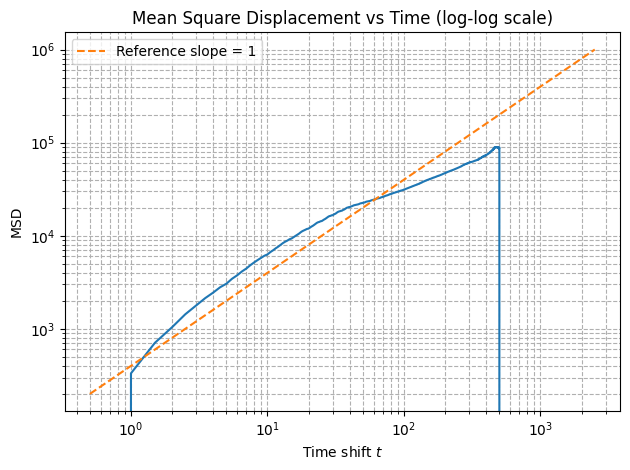

In [2]:
#Massimiliano Toffoli 01-07-2025

# using Algorithm 2 

def msd(pos, origin_freq, max_corr, tmax,npart):
    
    """
    Function to calculate the mean square displacement (MSD) of a system of particles.
    """
    


    time0 = np.zeros(max_corr) #set array with origin with times 
    sample_counter = np.zeros(max_corr) # array with times of time origins
    MSD = np.zeros(max_corr)#set all MSD to zero
    t0 = 0 #counter for origin amount
    x = np.zeros((max_corr, npart, 3))
    r = pos
    
    #sample and set origin
    for t in range(min(tmax, pos.shape[0])): # avoids getting out of bounds for arrays like r[t] since tmax could be bigger than pos
        if t%origin_freq==0: #add new origins
            tt0 = t0 % max_corr
            t0 = t0 +1 #update newest origin
            time0[tt0] = t
            #set origin for this step
            for i in range (0,npart):
                x[tt0][i] = r[t][i]
            
        #sampling part
        for dt in range (0, min(t0, max_corr)):
            corr_time = int(t - time0[dt] + 1) # time difference
            if 0 <= corr_time < max_corr: #changed this from the pseudo algorithm as the corr_time array would be otherwise out of bounds
                sample_counter[corr_time] = sample_counter[corr_time] + 1
                Dr2 = 0
                for i in range (0,npart):
                    dx = r[t][i][0] - x[dt][i][0] #calculate the cartesian coordinates for all positions
                    dy = r[t][i][1] - x[dt][i][1] #calculate the cartesian coordinates for all positions
                    dz = r[t][i][2] - x[dt][i][2] #calculate the cartesian coordinates for all positions
                    Dr2 = Dr2 + dx*dx  + dy *dy + dz*dz #calculate squared radial distance between current and original position
                    
                MSD[corr_time] = MSD[corr_time]+Dr2 #get mean MSD for time difference t
                
                
    for corr_time in range (1, max_corr): 
        if sample_counter[corr_time] > 0: #avoids division by zero
       
            MSD [corr_time] = MSD[corr_time] /sample_counter[corr_time]
           
          
    return MSD
 
npart = convert_lampps_to_xyz("traj_v2.lammpstrj","trajectory.xyz") #call the function to convert the LAMMPS trajectory file to an XYZ file
xyz_data = read_xyz("trajectory.xyz") #read the XYZ file and store the data in a variable  
#print(xyz_data) #print the data to check if it was read correctly

pos = xyz_data
origin_freq = 10
max_corr = 5000
tmax = 400000
 
MSD = msd (pos, origin_freq, max_corr, tmax, npart)       


dt = 0.5 # timestep used for the chosen MD file
time = np.arange(len(MSD)) * dt #creates time array of physical times
valid_times = time > 0 #take only the valid times since log of zero cannot be used


C = 400
ref_line = C * time # take a reference line with slope 1 to see how well it matches with the curve, C is just a coeffiicient to align the curve with the msd plot
plt.loglog(time[valid_times], MSD[valid_times])   # plot log scales
plt.loglog(time[valid_times], ref_line[valid_times], '--', label="Reference slope = 1") #plot reference line
plt.xlabel('Time shift $t$')
plt.ylabel('MSD')
plt.title('Mean Square Displacement vs Time (log-log scale)')
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.legend()
plt.show()     
            
    
    

 


### Question 1.2

Write a function (named `diffusionEinstein`) that calculates the self-diffusion coefficient from the output of the `msd` function. Use the method you described in the caption of your MSD result in question 1.1.


## Answer 1.2
### Massimiliano Toffoli (5937930) 01-07-2025
<em style="color:Lightgreen">
The function below calculates the diffusion coefficient by calculating first the slope of the log-log function and then dividing it by 6 * the number of particles npart.
From the curve above a self diffusion coeffiient of 0.11 was obtained. By converting this value in SI units a value of 1.1 e-8 m^2/s, which matches the order of magnitude of results for CH4 from the literature (e.g. in Sui, Hg & Yao, Jun & Zhang, Lei. (2015). Molecular Simulation of Shale Gas Adsorption and Diffusion in Clay Nanopores. Computation. 3. 687-700. 10.3390/computation3040687. )
</em>

In [3]:
def diffusionEinstein (msd,time,npart):
    
    slope, intercept, _, _, _ = scp.stats.linregress(time, msd)
    D = slope / (6*npart)
    return D

diff_range = (time >= 10) & (time <= 100) # range where the slope is being calculated
D = diffusionEinstein(MSD[diff_range], time[diff_range], npart)

print (D)

0.11392529507467523


## Assignment Part 2: Finite size effects

As discussed in the class, some properties suffer from so-called finite-size effects due to hydrodynamic effects combined with the use of periodic boundary conditions. In this part of the assignment, you will investigate the finite size effects of self-diffusion coefficient.

### Question 2.1

Use the code of your MD assignment to simulate CH₄ with your thermostat. Run the simulation for at least three different simulation sizes: 362, 750 and 1500 CH₄ molecules, use the simulation settings shown in table 3. Note that these computations can take a long time, so start them at a convenient moment.

---

**Table 3**: Simulation parameters

---

```python
# Simulation parameters
Nfreq_pos = 10       # sample frequency position output
steps = 100000       # minimum length of simulation run [fs] (may be longer depending on your algorithm)
dt = 1               # timestep [fs]

# CH₄ methane
sigma = 3.72         # [angstrom]
epsilon = 148 * k_B  # [K]
mass = 16.04         # [g/mol]

# Phase point
rho = 358.4          # [kg/m^3] density
T = 150              # [K]
L = ...              # Compute yourself
nPart = 362..1500    # Number of atoms

```

---


##  Answer 2.1
### Massimiliano Toffoli (5937930) 01-07-2025



In [20]:
sample_freq = 10
n_steps = 100000
dt = 1
sigma = 3.72 # in Angstroms
epsilon = 148 * kB # in K
mass = 16.04 #g/mol
rho = 358.4 #in  kg/m^3
Rcut = 2.5 *sigma
nPart = [362,750,1500]
zeta = 0
T = 150   # in K
Tdamp = 100  # damping time constant for the thermostat in fs
dim = 3 # 3D
mass_kg = mass / 1000  # [kg/mol]


#first case
nPart1 = 362
V = (nPart1 * mass_kg / NA) / rho  # in cubic meter
L_meter = V ** (1/3)
L1 = L_meter * 1e10  # convert length in Angstroms
pos, Lbox = initGrid(L1, nPart1, dim) # get positions and box sizes
Q1 = 3*nPart1 *kB * T * Tdamp**2  # damping coefficient for the thermostat
vel1 = initVel(nPart1, T, dim, mass)  # Initialize velocities for the particles
pos_final1, vel_final1, F_final1 = MDSolve_v2(nPart1, pos,T, vel1, mass, Lbox, Rcut, epsilon, sigma,dt, n_steps, sample_freq,Q1,zeta,log_file='log_A3_1.dat',traj_file='traj_A3_1.lammpstrj')

#second case

nPart2 = 750
V = (nPart2 * mass_kg / NA) / rho  # in cubic meter
L_meter = V ** (1/3)
L2 = L_meter * 1e10  # convert length in Angstroms
pos2, Lbox = initGrid(L2, nPart2, dim) # get positions and box sizes
Q2 = 3*nPart2 *kB * T * Tdamp**2  # damping coefficient for the thermostat
vel2 = initVel(nPart2, T, dim, mass)  # Initialize velocities for the particles
pos_final2, vel_final2, F_final2 = MDSolve_v2(nPart2, pos2,T, vel2, mass, Lbox, Rcut, epsilon, sigma,dt, n_steps, sample_freq,Q2,zeta,log_file='log_A3_2.dat',traj_file='traj_A3_2.lammpstrj')

#second case

nPart3 = 1500
V = (nPart3 * mass_kg / NA) / rho  # in cubic meter
L_meter = V ** (1/3)
L3 = L_meter * 1e10  # convert length in Angstroms
pos3, Lbox = initGrid(L3, nPart3, dim) # get positions and box sizes
Q3 = 3*nPart3 *kB * T * Tdamp**2  # damping coefficient for the thermostat
vel3 = initVel(nPart3, T, dim, mass)  # Initialize velocities for the particles
pos_final3, vel_final3, F_final3 = MDSolve_v2(nPart3, pos3,T, vel3, mass, Lbox, Rcut, epsilon, sigma,dt, n_steps, sample_freq,Q3,zeta,log_file='log_A3_3.dat',traj_file='traj_A3_3.lammpstrj')

AttributeError: Module 'scipy' has no attribute 'Boltzmann'

### Question 2.2

Plot your estimated self-diffusion coefficient as a function of the box size.  
Put $1/L$ (or $1/N^{1/3}$) on the x-axis and the self-diffusion coefficient on the y-axis.



### Question 2.3

Create another function (named `correctionYehHammer`) that computes the finite size correction ($D_i^{\text{corr}}$)  
(given experimental viscosity $\eta$) (During the lecture, we explicitly said that in such computations the viscosity should also be the one computed from MD. Here you can you the experimental data (e.g., from NIST database) for simplicity) and adds this to the already computed self-diffusion coefficient ($D_i^{\text{MD}}$):

$$
D_i^{\infty} = D_i^{\text{MD}} + D_i^{\text{corr}} = D^{\text{MD}} + \frac{k_B T \, \xi}{6 \pi \eta L}
$$

The box size is indicated by $L$ and the dimensionless constant for cubic lattices $\xi = 2.837298$.  
Plot the corrected self-diffusion coefficient as a function of $1/L$.


## Assignment Part 3: Production of transport properties

Use your MD code (from assignment 2) to produce long trajectories for different temperatures (see below Algorithm 4 for detailed settings).  
Compute the self-diffusion coefficients of methane using your own trajectories.  
Plot your finite size corrected results and compare with experimental results.

---

**Algorithm 4**: Simulation parameters

---

```python
# Simulation parameters
Nfreq_pos = 10       # sample frequency position output
steps = 250000       # minimum length of simulation run [fs] (may be longer depending on your algorithm)
dt = 1               # timestep [fs]

# CH₄ methane
sigma = 3.72         # [angstrom]
epsilon = 148 * k_B  # [K]
mass = 16.04         # [g/mol]

# Phase point
rho = 358.4          # [kg/m^3] density
T = [200, 300, 400]  # [K]
L = ...              # Compute yourself
nPart = 362          # Number of atoms
```
---